# Differential Privacy

*Author: Grant McKenzie [grant.mckenzie@mcgill.ca | https://grantmckenzie.com]*

This tutorial presents an introduction to differential privacy, a mathematical framework for ensuring the privacy of individuals or records in datasets.  Through this tutorial we will explore differential privacy applied to our micromobility trip dataset.

## Modules

First, we require a number of python modules in order to run this tutorial.  We will use `pandas` for handling all of our data, `matplotlib` for our plotting, and `PyDP` for all of our Differential Privacy functions.

In [125]:
#Import the Differential Privacy module
import pydp as dp 
from pydp.algorithms.laplacian import BoundedStandardDeviation, BoundedMean, Count, Max

# Other important modules for data handling, manipulation, and visualization
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt

## Data

Let's load some data.  Our dataset for this tutorial is a sample of 1000 points.  These points are the origins of e-scooter trips in the Brussels, Belgium.  We will read the CSV into a dataframe using `pandas`.

In [126]:
trip_origins = pd.read_csv("../data/Brussels_Jump1000.csv")

# For simplicity, lets round all of our Distance to the nearest metre (integers are easier to deal with than floats)
trip_origins.Distance = round(trip_origins.Distance).astype(int)

# Look at the first few records of the dataset.
trip_origins.head()

,Plate,Latitude,Longitude,Timestamp,Duration,Distance
0,BWN768,50.824148,4.359832,1561592243,366,1141
1,QCJ420,50.813293,4.348033,1561592132,477,822
2,RIY668,50.794780,4.416102,1561592063,837,4118
3,BYD553,50.848658,4.393357,1561593088,294,1199
4,HIL845,50.832895,4.441163,1561592421,1149,2422


Let's take a look at the trip distances using a histogram.  Note the outliers.  These will be important later.

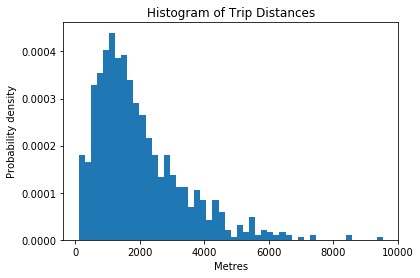

In [127]:
# Number of bins for the histogram
num_bins = 50    

# Set up the plot containers
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(trip_origins.Distance, num_bins, density=True)

# Lables
ax.set_xlabel('Metres')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Trip Distances')

# Show it
plt.show()

## Original vs. Private Statistics

Differential Privacy is designed to add noise to your dataset such that you would not be able to identify a difference between two datasets, one with the full data, and one with a single record removed.  To start, let's see what differential privacy does when calculating the mean trip distance from our dataset.

In [128]:
# Basic function to calculate the real mean of our trip distances
def true_mean() -> float:
    return statistics.mean(list(trip_origins.Distance))

This next function is designed to calculate the differentially private mean of our trip distances.  Note that this takes in a 'privacy budget' parameter.  This is a value between 0 and 1 with 0 indicating that the method should not give up any private information.  In practice, you need to provide a value larger than 0 for this to be useful.  The other parameters are here and worth exploring: https://pydp.readthedocs.io/en/latest/pydp.html

In [129]:
def private_mean(privacy_budget: float) -> float:
    x = BoundedMean(privacy_budget, 0, 1, 10000)
    return x.quick_result(list(trip_origins.Distance))

See the values of 1 and 10000 in the code above? These are the lower and upper bounds the differential privacy module uses when calculating the mean.  These really should be the minimum trip distance and maximum trip distance, respectively.  Changing these will have an impact on the output of your analysis though.  What might that impact be?

In [130]:
max(trip_origins.Distance)

9540

Go up to the `private_mean()` function and change the value of 10000 to the real max of the dataset.

In [131]:
print("Real Mean: ", true_mean())
print("Private Mean: ", private_mean(1))

Real Mean:  1960.359
Private Mean:  1941.1108696400643


Re-run the code above a few times.  What happened?  Why is this important?

Let's introduce a threshold.  How many trips in the dataset where greater than 5000 metres in length?

In [132]:
def true_count_above(limit: int) -> int:
    return trip_origins[trip_origins.Distance > limit].count()[0]

def private_count_above(privacy_budget: float, limit: int) -> int:
    x = Count(privacy_budget, dtype="int")
    return x.quick_result(list(trip_origins[trip_origins.Distance > limit]["Distance"]))

Run the code below, note the results, then change the privacy budget to a value less than 1, and run it again.

In [133]:
print("Above 5000:\t" + str(true_count_above(5000)))
print("DP Count Above 5000:\t" + str(private_count_above(1, 5000)))

Above 5000:	40
DP Count Above 5000:	39


Next, we can do the same analysis but for the 'standard deviation' of trip distances in the dataset

In [134]:
def true_sd() -> float:
    return statistics.stdev(list(trip_origins.Distance))

def private_sd(privacy_budget: float) -> float:
    x = BoundedStandardDeviation(privacy_budget, 0, 1, 10000)
    return x.quick_result(list(trip_origins.Distance))

Run the code below, note the results, then change the privacy budget to a value less than 1, and run it again.

In [139]:
print("True Standard Deviation:\t" + str(true_sd()))
print("Private Standard Deviation:\t" + str(private_sd(1)))

True Standard Deviation:	1360.8547188016378
Private Standard Deviation:	1260.0815517309522


Finally, we can do the same analysis but for the `max` trip distances in the dataset.  This is where it gets a bit more interesting.  Descriptive statistics like mean and count consider the entire dataset but when we deal with stats like max or min, we are pulling out a very specific part of our dataset.  If you have outliers in your data this can make it very difficult for a differential privacy approach to produce reasonable results.  Why is that?

In [109]:
def true_max() -> int:
    return max(list(trip_origins.Distance))

def private_max(privacy_budget: float) -> int:
    x = Max(epsilon = privacy_budget, lower_bound = 0, upper_bound = 10000, dtype="int")
    return x.quick_result(list(trip_origins.Distance))

Run the code below, note the results, then change the privacy budget to a value less than 1, and run it again.

In [111]:
print("True max:\t" + str(nondp_max()))
print("Private max:\t" + str(private_max(1)))

True max:	9540
Private max:	4412


## Visualize
Lastly, I find it useful to visualize some of these data to see the differences between the original and the differentially private dataset.

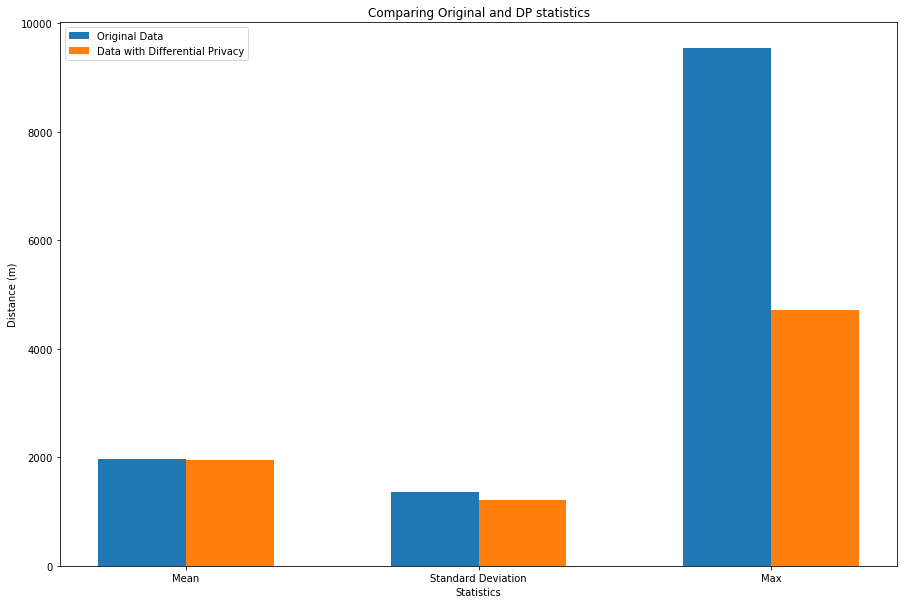

In [146]:
 # Numbers of pairs of bars you want
N = 3

# Specify the values of true data - blue bars (height)
blue_bar = (true_mean(),true_sd(), true_max())
# Specify the values of privatized data - orange bars (height)
orange_bar = (private_mean(1),private_sd(1), private_max(1))

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,10))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='Original Data')
plt.bar(ind + width, orange_bar, width, label='Data with Differential Privacy')

plt.xlabel('Statistics')
plt.ylabel('Distance (m)')
plt.title('Comparing Original and DP statistics')

# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Mean', 'Standard Deviation', 'Max'))

# Place the legend
plt.legend(loc='best')
plt.show()

### The End